In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.RandomCrop(imsize),
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    
    return image.to(device, torch.float)


style_img = image_loader("./images/styles/picasso.jpg")
content_img = image_loader("./images/content/dancing.jpg")

print(style_img.shape, content_img.shape)
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


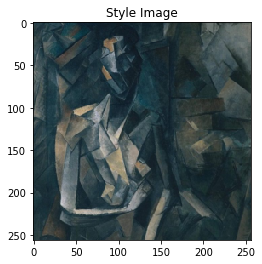

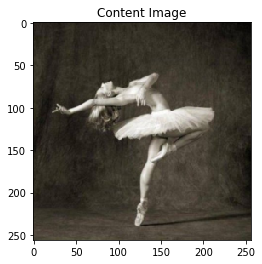

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [6]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [7]:
cnn = models.vgg16_bn(pretrained=True).features.to(device).eval()

In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [9]:
content_layers_default = ['relu_7']
style_layers_default = ['relu_2', 'relu_4', 'relu_7', 'relu_10']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

torch.Size([1, 3, 256, 256])


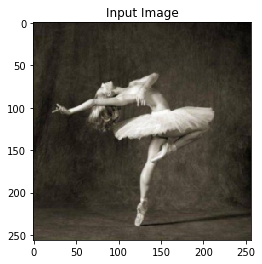

In [10]:
input_img = content_img.clone() #torch.randn(1,3,128,128)
print(input_img.shape)
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing.. {}'.format(optimizer))
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=10, content_weight=1, num_steps=300)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [36]:
class ImageTransformation(nn.Module):

    def __init__(self):
        super(ImageTransformation, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)
        self.bn6 = nn.BatchNorm2d(3)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.res1(x))
        x = F.relu(self.res2(x))
        x = F.relu(self.res3(x))
        x = F.relu(self.res4(x))
        x = F.relu(self.res5(x))
        
        x = F.interpolate(x, mode='nearest', scale_factor=2)
#         print("After res5", x.shape)
        x = F.relu(self.bn4(self.conv4(x)))
#         print("After conv4", x.shape)
        x = F.interpolate(x, mode='nearest', scale_factor=2)
        x = F.relu(self.bn5(self.conv5(x)))
#         print("After conv5", x.shape)
        x = self.bn6(self.conv6(x))
#         print("After conv6", x.shape)
#         x = ((torch.tanh(x) + 1) / 2.0)
        return x
        
class ResidualBlock(nn.Module):
    def __init__(self, chan):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(chan, chan, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(chan)
        self.conv2 = nn.Conv2d(chan, chan, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(chan)
        
    def forward(self, x):
        residual = x
        
        x = self.bn1(self.conv1(x))
        x = F.relu(x)
        
        x = self.bn2(self.conv2(x))
        
        return x + residual

In [42]:
def loss_net(cnn, normalization_mean, normalization_std, 
             content_img, style_img, input_img, style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    loss_model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    
    loss_model(input_img)
    style_score = 0
    content_score = 0

    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss

    style_score *= style_weight
    content_score *= content_weight

    return style_score + content_score

torch.Size([1, 3, 256, 256])


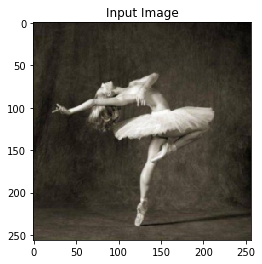

In [43]:
input_img = content_img.clone() #torch.randn(1,3,128,128)
print(input_img.shape)
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [44]:
image_transform_net = ImageTransformation()
optimizer = optim.Adam(image_transform_net.parameters())

for i in range(10):
    optimizer.zero_grad()
    y_hat = image_transform_net(input_img)
    loss = loss_net(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, y_hat)
    print("Itr: {} Loss: {}".format(i, loss.item()))
    loss.backward()
    optimizer.step()

Building the style transfer model..
Itr: 0 Loss: 8138441.5
Building the style transfer model..
Itr: 1 Loss: 3462704.25
Building the style transfer model..
Itr: 2 Loss: 3172750.75
Building the style transfer model..
Itr: 3 Loss: 3088877.75
Building the style transfer model..
Itr: 4 Loss: 3042591.5
Building the style transfer model..
Itr: 5 Loss: 3007902.75
Building the style transfer model..
Itr: 6 Loss: 2980368.5
Building the style transfer model..
Itr: 7 Loss: 2954279.0
Building the style transfer model..
Itr: 8 Loss: 2928553.25
Building the style transfer model..
Itr: 9 Loss: 2902555.75


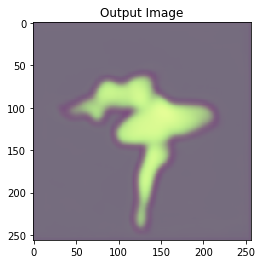

In [45]:
output = image_transform_net(input_img)
output = torch.sigmoid(output)
plt.figure()
imshow(output, title='Output Image')

plt.show()